## 4rd notebook for improving the counter
This notebook contains the final attempt to have a principled approach for counting. 

The idea is to first consider a set of segmentations, and then for each segmentation determine a probability. The probability is the product of segment probabilities with an additional punishment for the amount of patches that overlap, which is a hyperparameter than can be tuned. The goal is to find some probabilistic model that maps the segmentations to truthful probabilities.

### 1. Load utilities

In [1]:
import sys
sys.path.append("../")
sys.path.append("../amnesic_probing/")
sys.path.append("../amnesic_probing/")
sys.path.append("../../../")
import transformer_patches
import utils
import torch
import pickle
import numpy as np
import copy

In [2]:
def get_binding_probe(layer, modelname, mode):
    D_in = 2 * 768
    D_out = 2

    dataset_totrain = "pos"
    padding_up_to = None
    layernorm = False
    amnesic_obj = None
    first_projection_only = False

    model_path = f'../../models/{modelname}_layer{layer}_0_{dataset_totrain}_binding_problem_{"filtered_" + str({padding_up_to}) if padding_up_to is not None else "unfiltered"}_{"layernorm" if layernorm else "no_layernorm"}{"_amnesic" + str({amnesic_obj}) if amnesic_obj is not None else ""}{"_firstprojectiononly" if first_projection_only else ""}{"_normalmode" if mode is None else f"_mode:{mode}"}.pt'

    model = utils.open_model(D_in, D_out, layernorm, modelname)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    print("loaded model: ", model_path)

    return model

binding_probe_normal = get_binding_probe(7, "MLP2", "normal_OLD")


loaded model:  ../../models/MLP2_layer7_0_pos_binding_problem_unfiltered_no_layernorm_mode:normal_OLD.pt


In [3]:
def get_detect_probe(layer, modelname):

    dataset = "pos"
    layernorm = False

    detect_path = f"../../models/{modelname}_layer{layer}_{dataset}_object_det.pt"
    detect_probe = utils.open_model(768, 2, layernorm, modelname)
    detect_probe.load_state_dict(torch.load(detect_path))
    detect_probe.eval()

    print("loaded model: ", detect_path)

    return detect_probe

detect_probe = get_detect_probe(7, "MLP2")

loaded model:  ../../models/MLP2_layer7_pos_object_det.pt


In [4]:
def get_representations(dataset, split):
    file = f"{dataset}_{split}_visual.pickle"

    with open(f"../../data/{dataset}/representations/" + file, "rb") as f:
        reprs = pickle.load(f)

    return reprs

reprs = get_representations("pos", "train")
    

In [5]:
def stack_reprs_2patches(patch1, patch2, repr, layer):

    input1 = utils.filter_repr(
        layer, [patch1], repr, single_patch=True, padding_up_to=None
    )
    input2 = utils.filter_repr(
        layer, [patch2], repr, single_patch=True, padding_up_to=None
    )
    z = torch.stack(
        [torch.from_numpy(input1[0]), torch.from_numpy(input2[0])]
    ) 
    z = z.flatten()
    return z

In [6]:
def same_object(patch_id1, patch_id2, model, reprs, layer):
    # Check whether patch_id1 and patch_id2 are the same object twice (in both directions)
    z1 = stack_reprs_2patches(patch_id1, patch_id2, reprs, layer)
    z2 = stack_reprs_2patches(patch_id2, patch_id1, reprs, layer)

    input = torch.stack((z1, z2))

    out = model.forward(input)
    y1, y2 = torch.softmax(out, dim=1)
    prob = np.mean(
        (y1[1].item(), y2[1].item())
    )  # weighted average of probabilities in both directions

    return 1 if prob >= 0.5 else 0

In [7]:
def get_prob_same_object(patch_id1, patch_id2, model, reprs, layer):
    # Check whether patch_id1 and patch_id2 are the same object twice (in both directions)
    z1 = stack_reprs_2patches(patch_id1, patch_id2, reprs, layer)
    z2 = stack_reprs_2patches(patch_id2, patch_id1, reprs, layer)

    input = torch.stack((z1, z2))

    out = model.forward(input)
    y1, y2 = torch.softmax(out, dim=1)
    prob = np.mean(
        (y1[1].item(), y2[1].item())
    )  # weighted average of probabilities in both directions

    return prob

### 2. Obtain possible segmentations

../../data/pos/images/test/2.png
(1478, 1478)


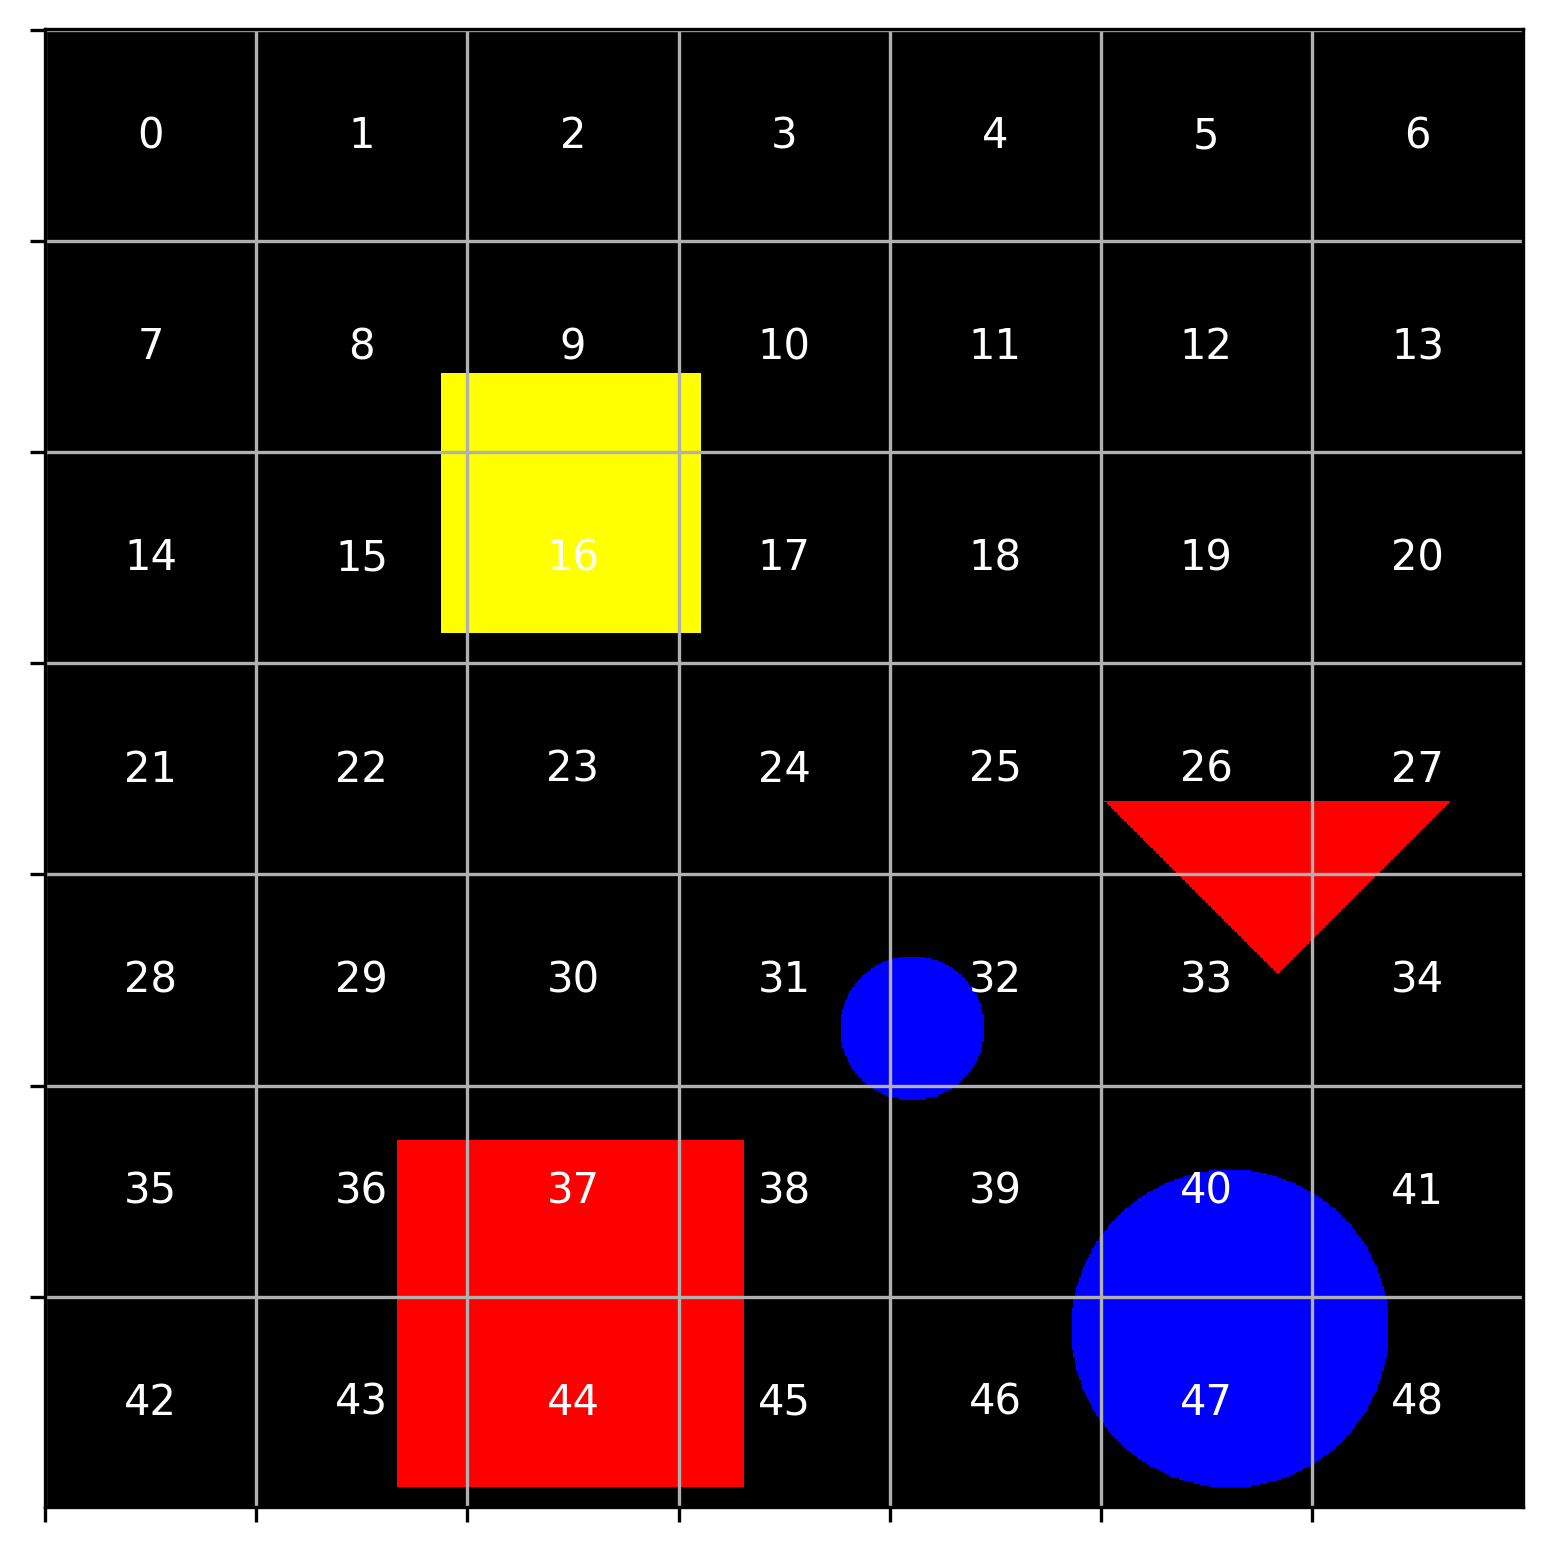

In [11]:
import transformer_patches
import counter

img_id = "2"
patches = transformer_patches.get_all_patches_with_objects(f'{img_id}.png', "pos", "test", global_path="../..")
transformer_patches.open_image_withpatches(f"{img_id}.png", "pos", "test", to_save=False, global_path="../..")

In [35]:
import random

def get_object_set(patch0, patches, model, reprs, layer):

    object_set = set()
    neighbors = utils.get_neighboring_patches(patch0)
    probs = []

    object_set.add(patch0)
    patches_to_explore = []
    prob_singleton = []

    for neighbor in neighbors:
        if neighbor in patches:
            prob = get_prob_same_object(patch0, neighbor, model, reprs, layer)
            if prob >= 0.5:
                object_set.add(neighbor)
                patches_to_explore.append((neighbor))
                probs.append(prob)
            else:
                prob_singleton.append(1-prob)
        else:
            prob_singleton.append(1)

    history = copy.deepcopy(neighbors)

    while len(patches_to_explore) != 0:

        edge = patches_to_explore.pop()
        history.append(edge)
        neighbors = utils.get_neighboring_patches(edge)
        for neighbor in neighbors:
            if neighbor in patches:
                prob = get_prob_same_object(patch0, neighbor, model, reprs, layer)
                # if prob >= np.mean(probs):
                if prob >= 0.5:
                    object_set.add(neighbor)
                    probs.append(prob)
                    if neighbor not in history:
                        patches_to_explore.append(neighbor)
                elif same_object(edge, neighbor, model, reprs, layer):
                    # if random.random() < prob:
                    if get_prob_same_object(patch0, neighbor, model, reprs, layer) > 0.3:
                        # Different probabilities:
                            # - 0.3: 0.7045 --> best
                            # - 0.2: 0.688
                            # - 0.4: 0.7015
                        object_set.add(neighbor)
                        probs.append(prob)
                        if neighbor not in history:
                            patches_to_explore.append(neighbor)
    
    if len(object_set) == 1:
        probs = prob_singleton

    return object_set, probs

In [48]:
import counter
from collections import defaultdict
import random

# def get_object_sets(reprs, layer, binding_probe, detect_probe, start_explore):

#     object_patches = counter.get_object_patches(detect_probe, reprs, layer)
#     object_patches_to_explore = copy.deepcopy(object_patches)
#     object_sets = set()
#     probs_dict = defaultdict(lambda: [])
#     # random.shuffle(object_patches)
#     # print("starting from patch ", object_patches[0])

#     for patch_id in range(start_explore, len(object_patches)+start_explore):
#         # print(patch_id)
#         patch_id = patch_id % len(object_patches)
#         patch = object_patches[patch_id]
#     # for patch in object_patches:
#         if patch in object_patches_to_explore:

#             object_set, prob = get_object_set(
#                 patch, copy.deepcopy(object_patches), binding_probe, reprs, layer
#             )
#             for patch in object_set:
#                 if patch in object_patches_to_explore:
#                     object_patches_to_explore.remove(patch)
#             object_sets.add(frozenset(object_set))
#             probs_dict[frozenset(object_set)].append(prob)

#     return object_sets, probs_dict

def get_object_sets(reprs, layer, binding_probe, detect_probe):
    object_patches = counter.get_object_patches(detect_probe, reprs, layer)
    object_patches_to_explore = copy.deepcopy(object_patches)
    object_sets = set()
    random.shuffle(object_patches)

    for patch in object_patches:
        if patch in object_patches_to_explore:
            object_set, _ = get_object_set(
                patch, copy.deepcopy(object_patches), binding_probe, reprs, layer
            )
            for patch in object_set:
                if patch in object_patches_to_explore:
                    object_patches_to_explore.remove(patch)
            # print("object_sets", object_sets)
            # print(object_set)
            # print(frozenset(object_set))
            object_sets.add(frozenset(object_set))

    return object_sets

In [51]:
def get_n_segmentations(n, reprs, layer, binding_probe, detect_probe):
    segmentations = []
    for i in range(n):
        object_sets = get_object_sets(reprs, layer, binding_probe, detect_probe)
        segmentations.append(object_sets)
    return segmentations

In [52]:
segmentations = get_n_segmentations(5, reprs[img_id], 7, binding_probe_normal, detect_probe)

### 3. From the given segmentations, make a probability score

In [30]:
from itertools import combinations

def get_prob_objectset(object_set, model, reprs, layer):
    probs = {}
    if len(object_set) == 1:
        patch = list(object_set)[0]
        neighbors = utils.get_neighboring_patches(patch)
        other_probs = []
        for neighbor in neighbors:
            other_probs.append(
                get_prob_same_object(patch, neighbor, model, reprs, layer)
            )
        probs[(patch, patch)] = 1 - np.mean(other_probs)
    for patch0, patch1 in list(combinations(object_set, 2)):
        prob = get_prob_same_object(patch0, patch1, model, reprs, layer)
        probs[(patch0, patch1)] = prob
    return probs

In [17]:
from itertools import combinations

def get_prob_objectset(object_set, model, reprs, layer):
    # object_set is a set of ints (i.e. patches)
    probs = {}
    if len(object_set) == 1:
        # print(object_set)
        # print()
        patch = list(object_set)[0] # check if this works
        # print(patch)
        neighbors = utils.get_neighboring_patches(patch)
        other_probs = []
        for neighbor in neighbors:
            other_probs.append(get_prob_same_object(patch, neighbor, model, reprs, layer))
        probs[(patch, patch)] = 1 - np.mean(other_probs) 
    for patch0, patch1 in list(combinations(object_set, 2)):
        prob = get_prob_same_object(patch0, patch1, model, reprs, layer)
        probs[(patch0, patch1)] = prob
    return probs

In [18]:
def get_probability(segmentation, binding_probe, reprs, layer):
    accumulative_prob = []
    for object in segmentation:
        # print(object)
        scores = get_prob_objectset(object, binding_probe, reprs, layer)
        # print("scores: ", scores)
        # print(scores.values())
        prob = np.product(list(scores.values()))
        # print(prob)
        accumulative_prob.append(prob)
    
    # return np.mean(accumulative_prob)
    return np.product(accumulative_prob)

In [19]:
def count_from_segmentations(segmentations, binding_probe, reprs, layer):
    counts = []
    probs = []
    for segmentation in segmentations:
        probs.append(get_probability(segmentation, binding_probe, reprs, layer))
        counts.append(len(segmentation))
    # print("counts: ", counts)
    # print("probs: ", probs)
    return int(np.round((np.average(counts, weights=probs))))

### Example

In [21]:
def get_representations(dataset, split):
    file = f"{dataset}_{split}_visual.pickle"

    with open(f"../../data/{dataset}/representations/" + file, "rb") as f:
        reprs = pickle.load(f)

    return reprs

reprs = get_representations("pos", "test")
    

../../data/pos/images/test/4.png
(1478, 1478)


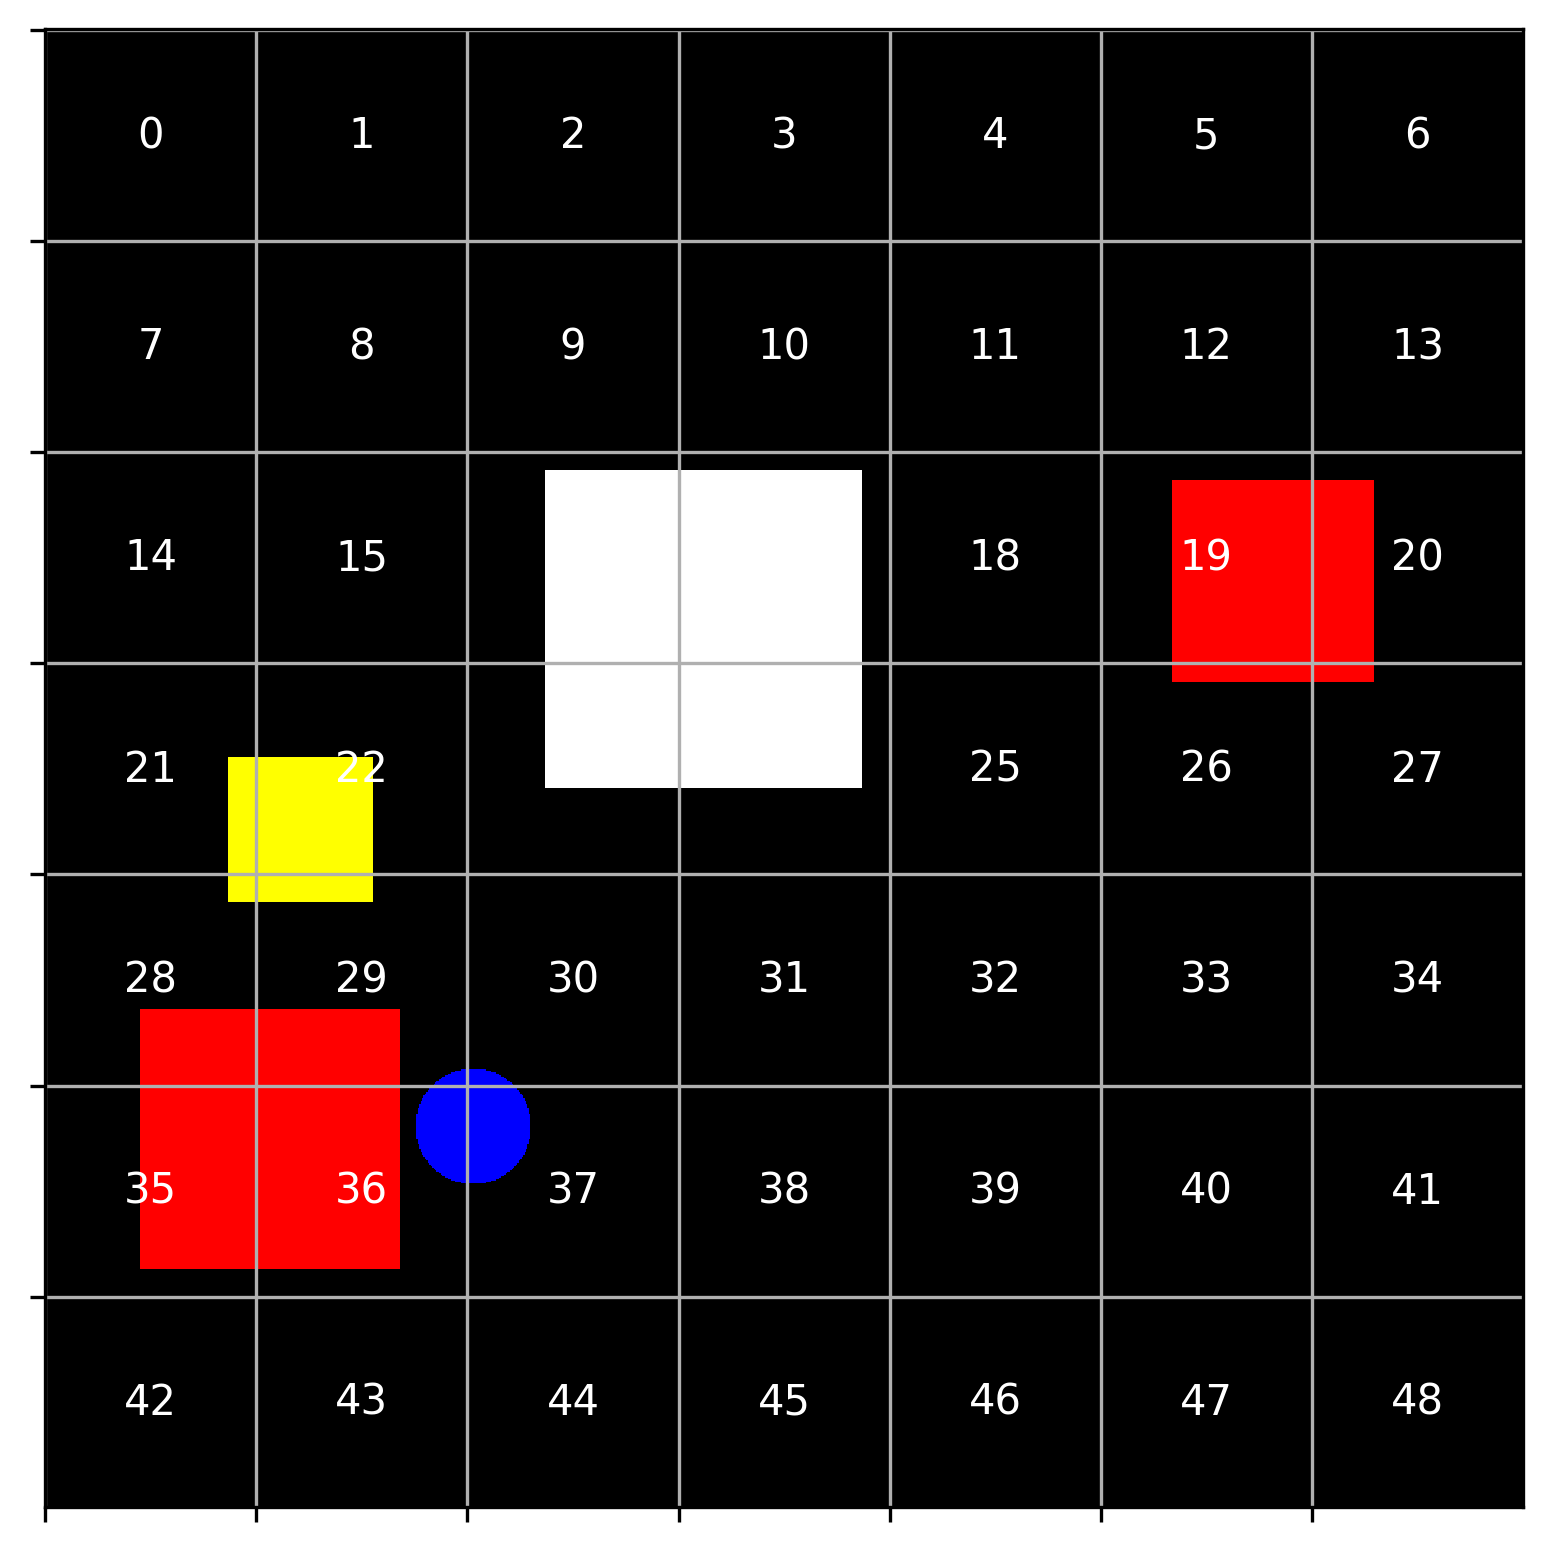

In [55]:
img_id = "4"
patches = transformer_patches.get_all_patches_with_objects(f'{img_id}.png', "pos", "test", global_path='../..')
transformer_patches.open_image_withpatches(f"{img_id}.png", "pos", "test", to_save=False, global_path="../..")

In [60]:
# img_id = "5"
n_segmentations = get_n_segmentations(3, reprs[img_id], 7, binding_probe_normal, detect_probe)
for segm in n_segmentations:
    print(get_probability(segm, binding_probe_normal, reprs[img_id], 7))
    # print(segm)
print(n_segmentations)

count = count_from_segmentations(n_segmentations, binding_probe_normal, reprs[img_id], 7)
print(count)

7.272547083988937e-08
0.12578729414898426
0.12578729414898424
[{frozenset({24, 16, 17, 23}), frozenset({35, 36, 37, 28, 29, 30}), frozenset({29, 28, 21, 22}), frozenset({27, 26, 19, 20})}, {frozenset({35, 28, 29, 36}), frozenset({29, 36, 37, 30}), frozenset({27, 26, 19, 20}), frozenset({16, 17, 24, 23}), frozenset({21, 22})}, {frozenset({35, 28, 29, 36}), frozenset({29, 36, 37, 30}), frozenset({27, 26, 19, 20}), frozenset({21, 22}), frozenset({16, 17, 24, 23})}]
5


### Experiment

In [ ]:
import pickle
import utils

def experiment(dataset, split, layer, binding_probe, detect_probe):

    reprs = get_representations(dataset, split)
    annotation = utils.get_annotation(dataset, split)

    layernorm = False
    
    predictions = []
    labels = []

    i = 0
    for img_id, repr in reprs.items():

        # object_sets, _ = get_object_sets(repr, layer, binding_probe, detect_probe)
        n_segmentations = get_n_segmentations(2, repr, layer, binding_probe, detect_probe)
        # print(n_segmentations)
        count = count_from_segmentations(n_segmentations, binding_probe, repr, layer)
        
        # object_sets_edited = find_overlapping_objectsets_v2(object_sets, repr, layer, binding_probe)
        # predictions.append(len(object_sets))
        predictions.append(count)
        labels.append(int(annotation[img_id][0]['n_objects']))

        if i % 10 == 0:
            print(f"{i}/{len(reprs)}: {img_id}.png, {count} vs. {int(annotation[img_id][0]['n_objects'])}, pred vs. true")
            # print(f"{i}/{len(reprs)}: {img_id}.png, {len(object_sets)} vs. {int(annotation[img_id][0]['n_objects'])}, pred vs. true")
        i += 1

    return predictions, labels

In [ ]:
# predictions, labels = experiment("pos", "test", 7, binding_probe_normal, detect_probe)
# print(predictions)
# print(labels)

In [ ]:
# print(counter.get_error(predictions, labels))
# print(counter.get_accuracy(predictions, labels))